In [2]:
import os
import requests
import pandas as pd
import geopandas as gpd
import sys
import datetime
sys.path.append("../morpc-common/")
import morpc

In [80]:
OUTPUT_DIR = './output_data'
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

In [81]:
data_raw, resource, schema = morpc.frictionless_load_data('../morpc-renewenergyfacilities-standardize/output_data/renewable_portfolio_standard_facilities.resource.yaml')

morpc.load_frictionless_data | INFO | Loading Frictionless Resource file at location ..\morpc-renewenergyfacilities-standardize\output_data\renewable_portfolio_standard_facilities.resource.yaml
morpc.load_frictionless_data | INFO | Loading data, resource file, and schema from their source locations
morpc.load_frictionless_data | INFO | --> Data file: ..\morpc-renewenergyfacilities-standardize\output_data\renewable_portfolio_standard_facilities.csv
morpc.load_frictionless_data | INFO | --> Resource file: ..\morpc-renewenergyfacilities-standardize\output_data\renewable_portfolio_standard_facilities.resource.yaml
morpc.load_frictionless_data | INFO | --> Schema file: ..\morpc-renewenergyfacilities-standardize\output_data\renewable_portfolio_standard_facilities.schema.yaml
morpc.load_frictionless_data | INFO | Loading data.
frictionless_cast_field_types | INFO | Casting field Name Of Renewable Generating Facility as type string.
frictionless_cast_field_types | INFO | Casting field State as

In [65]:
data = data_raw.copy()
data['County'] = [x.replace(' County', '')for x in data['County']]
data['Year'] = [int(x.strftime('%Y')) for x in data['Approved']]

In [66]:
county_names = morpc.countyLookup(scope = "REGION15").list_names()

Loading data for MORPC 15-County region only


In [67]:
data = data.loc[data['County'].isin(county_names)]

<Axes: >

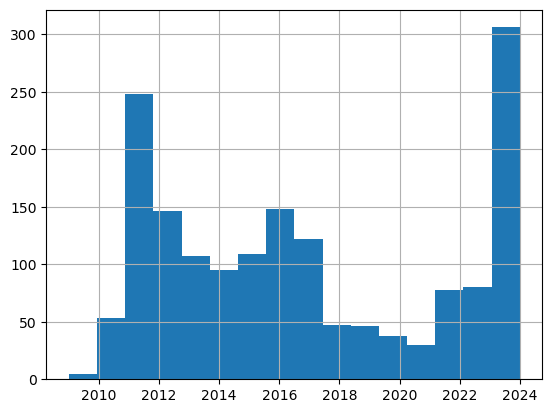

In [68]:
data['Year'].hist(bins=len(data['Year'].unique()))

In [69]:
def calc_counts_sums(data, index_col, year_col, type_col, sum_col):
    print(f"INFO | Calculating sums for {sum_col} and counts for {type_col}")
    data = data.copy()
    data['count'] = 1
    count_col = 'count'
    data['total'] = data[sum_col]
    data = data[[index_col, year_col, type_col, 'count', 'total']].groupby([index_col, year_col, type_col]).sum().reset_index()
    data = data.set_index([index_col, year_col])
    data = data.pivot(columns = [type_col]).fillna(0)
    data.columns = data.columns.map("_".join)
    columns = data.columns # Store columns to add zero observations later
    data = data.reset_index()
    return(data, columns)

def add_zeros_for_non_obs(data, index_col, year_col, columns):
    print("INFO | Adding zeros to empty observations.")
    # Add observations that have zeros so all combinations of index and year have a observation for all types.
    accounted_place = data[index_col].unique()	
    first_year = data[year_col].min()
    last_year = pd.Series([x for x in data[year_col] if x < 9999]).max()

    data_zeros = data.copy()
    for year in range(int(first_year), int(last_year)+1, 1):  # range stops at one less than the second parameter, hence the +1
        for place in accounted_place:
            if data_zeros[(data_zeros[year_col] == year) & (data_zeros[index_col] == place)].shape[0] == 0:
                entry = {
                    year_col: year,
                    index_col: place,
                }
                for c in columns:
                    entry[c] = 0
                
                data_zeros = pd.concat([data_zeros, pd.DataFrame.from_dict(entry, orient='index').transpose()], ignore_index=True)
    return (data_zeros)

def pivot_wide_to_long(data, index_col, preserve_cols, year_col, type_col):
    print("INFO | Pivoting to long format")
    data = data.melt(id_vars=list(pd.core.common.flatten([index_col, preserve_cols, year_col]))).rename(columns={'variable':type_col})
    data = data.sort_values([index_col, type_col, year_col])
    return(data)

In [72]:
data, columns = calc_counts_sums(data, 'County', 'Year', 'Technology', 'Capacity (MW)')

INFO | Calculating sums for Capacity (MW) and counts for Technology


In [73]:
wide = add_zeros_for_non_obs(data, 'County', 'Year', columns).sort_values(['County', 'Year'])

INFO | Adding zeros to empty observations.


In [75]:
wide['COUNTYFP'] = wide['County'].map(morpc.CONST_COUNTY_NAME_TO_ID)

In [76]:
long = pivot_wide_to_long(wide, 'County', 'COUNTYFP', 'Year', 'Technology')

INFO | Pivoting to long format


In [82]:
wide.to_csv(f'{OUTPUT_DIR}/morpc-rps-county-wide.csv', index=False)
long.to_csv(f'{OUTPUT_DIR}/morpc-rps-county-long.csv', index=False)  

In [92]:
region_wide = wide.drop(columns = ['County', 'COUNTYFP']).groupby(['Year']).sum().reset_index()

In [93]:
region_wide['Name'] = '15-County Region'
region_wide['GEOID'] = '001'

In [96]:
region_long = pivot_wide_to_long(region_wide, 'Name', 'GEOID', 'Year', 'Technology')

INFO | Pivoting to long format


In [98]:
region_wide.to_csv(os.path.join(OUTPUT_DIR, 'morpc-rps-region-wide.csv'), index=False)
region_long.to_csv(os.path.join(OUTPUT_DIR, 'morpc-rps-region-long.csv'), index=False)